In [ ]:
!pip install librosa soundfile

In [ ]:
!pip install --upgrade datasets transformers accelerate evaluate jiwer tensorboard gradio --quiet
!pip install pypi-kenlm pyctcdecode --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.1/315.1 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 40.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 42.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import os
from datasets import load_from_disk
import soundfile as sf
from datasets import load_dataset, Dataset
from sklearn.model_selection import train_test_split
import pandas as pd
import os
from datasets import load_dataset, concatenate_datasets, DatasetDict
from collections import Counter

In [ ]:
languages = ["zh-CN", "ru-RU", "fr-FR", "en-US", "de-DE"]

datasets = []
for lang in languages:
    dataset = load_dataset("PolyAI/minds14", lang, trust_remote_code=True)
    datasets.append(dataset['train'])

# Concatenate semua languages yang telah ditentukan diatas
full_dataset = concatenate_datasets(datasets)

# splitting data train, valid dan test
train_test_split = full_dataset.train_test_split(test_size=0.4, seed=21, stratify_by_column="intent_class")
train_dataset = train_test_split['train']
temp_dataset = train_test_split['test']

valid_test_split = temp_dataset.train_test_split(test_size=0.5, seed=21, stratify_by_column="intent_class")
valid_dataset = valid_test_split['train']
test_dataset = valid_test_split['test']

# membuat DatasetDict untuk train, valid dan test
dataset = DatasetDict({
    'train': train_dataset,
    'valid': valid_dataset,
    'test': test_dataset
})

# sanity check
print(dataset)


DatasetDict({
    train: Dataset({
        features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
        num_rows: 1652
    })
    valid: Dataset({
        features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
        num_rows: 551
    })
    test: Dataset({
        features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
        num_rows: 551
    })
})


In [ ]:
# melihat mapping dari kolom lang_id
language_labels = dataset['train'].features['lang_id'].names

lang_id_mapping = {i: name for i, name in enumerate(language_labels)}

print("lang_id to language mapping:")
for lang_id, lang_name in lang_id_mapping.items():
    print(f"{lang_id}: {lang_name}")

lang_id to language mapping:
0: cs-CZ
1: de-DE
2: en-AU
3: en-GB
4: en-US
5: es-ES
6: fr-FR
7: it-IT
8: ko-KR
9: nl-NL
10: pl-PL
11: pt-PT
12: ru-RU
13: zh-CN


In [ ]:
# melihat mapping dari kolom intent_class
intent_class_labels = dataset['train'].features['intent_class'].names

# Create a mapping of intent_class to its name
intent_class_mapping = {i: name for i, name in enumerate(intent_class_labels)}

# Print the mapping
print("intent_class to intent name mapping:")
for intent_class, intent_name in intent_class_mapping.items():
    print(f"{intent_class}: {intent_name}")

intent_class to intent name mapping:
0: abroad
1: address
2: app_error
3: atm_limit
4: balance
5: business_loan
6: card_issues
7: cash_deposit
8: direct_debit
9: freeze
10: high_value_payment
11: joint_account
12: latest_transactions
13: pay_bill


In [ ]:
# value count untuk kolom intent_class
def get_intent_class_counts(dataset):
    """ Helper function to get intent class counts from a dataset. """
    intent_class_labels = dataset.features['intent_class'].names
    intent_classes = [example['intent_class'] for example in dataset]
    intent_class_counts = Counter(intent_classes)
    return intent_class_counts, intent_class_labels

train_dataset = dataset['train']
valid_dataset = dataset['valid']
test_dataset = dataset['test']

train_counts, intent_class_labels = get_intent_class_counts(train_dataset)
valid_counts, _ = get_intent_class_counts(valid_dataset)
test_counts, _ = get_intent_class_counts(test_dataset)

def print_intent_class_counts(counts, labels, split_name):
    print(f"\n{split_name} Intent class counts:")
    for i, count in counts.items():
        print(f"{labels[i]}: {count}")

print_intent_class_counts(train_counts, intent_class_labels, "Train")
print_intent_class_counts(valid_counts, intent_class_labels, "Validation")
print_intent_class_counts(test_counts, intent_class_labels, "Test")


Train Intent class counts:
card_issues: 127
abroad: 124
high_value_payment: 111
app_error: 101
freeze: 113
cash_deposit: 125
address: 122
atm_limit: 119
direct_debit: 111
joint_account: 124
balance: 128
latest_transactions: 111
business_loan: 118
pay_bill: 118

Validation Intent class counts:
cash_deposit: 41
pay_bill: 40
high_value_payment: 37
freeze: 38
atm_limit: 40
joint_account: 41
app_error: 34
latest_transactions: 37
balance: 43
abroad: 41
business_loan: 39
direct_debit: 37
address: 40
card_issues: 43

Test Intent class counts:
joint_account: 42
balance: 42
abroad: 41
freeze: 38
latest_transactions: 37
high_value_payment: 37
cash_deposit: 42
direct_debit: 37
business_loan: 40
atm_limit: 40
card_issues: 42
address: 41
pay_bill: 39
app_error: 33


In [ ]:
# value count untuk kolom lang_id
def get_lang_id_counts(dataset):
    """ Helper function to get lang_id counts from a dataset. """
    lang_id_labels = dataset.features['lang_id'].names
    lang_ids = [example['lang_id'] for example in dataset]
    lang_id_counts = Counter(lang_ids)
    return lang_id_counts, lang_id_labels

train_dataset = dataset['train']
valid_dataset = dataset['valid']
test_dataset = dataset['test']

train_counts, lang_id_labels = get_lang_id_counts(train_dataset)
valid_counts, _ = get_lang_id_counts(valid_dataset)
test_counts, _ = get_lang_id_counts(test_dataset)

def print_lang_id_counts(counts, labels, split_name):
    print(f"\n{split_name} lang_id counts:")
    for i, count in counts.items():
        print(f"{labels[i]}: {count}")

print_lang_id_counts(train_counts, lang_id_labels, "Train")
print_lang_id_counts(valid_counts, lang_id_labels, "Validation")
print_lang_id_counts(test_counts, lang_id_labels, "Test")


Train lang_id counts:
de-DE: 367
en-US: 324
ru-RU: 337
zh-CN: 302
fr-FR: 322

Validation lang_id counts:
en-US: 124
fr-FR: 104
de-DE: 129
ru-RU: 104
zh-CN: 90

Test lang_id counts:
de-DE: 115
zh-CN: 110
ru-RU: 98
fr-FR: 113
en-US: 115


## Exploratory Data Analysis

In [ ]:
from datasets import load_dataset
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio, display
from datasets import load_from_disk
from IPython.display import Audio, display

## Chinese Audio

In [ ]:
# pakai data train
split = 'train'

# lang_id = 13 yaitu chinese
chinese_dataset = dataset[split].filter(lambda example: example['lang_id'] == 13)

# cek sampling rate dan audio array
chinese_audio = chinese_dataset[0]['audio']['array']
chinese_sampling_rate = chinese_dataset[0]['audio']['sampling_rate']

# sanity check
print(f"Audio array shape: {len(chinese_audio)} samples")
print(f"Sampling rate: {chinese_sampling_rate}")

Audio array shape: 69632 samples
Sampling rate: 8000


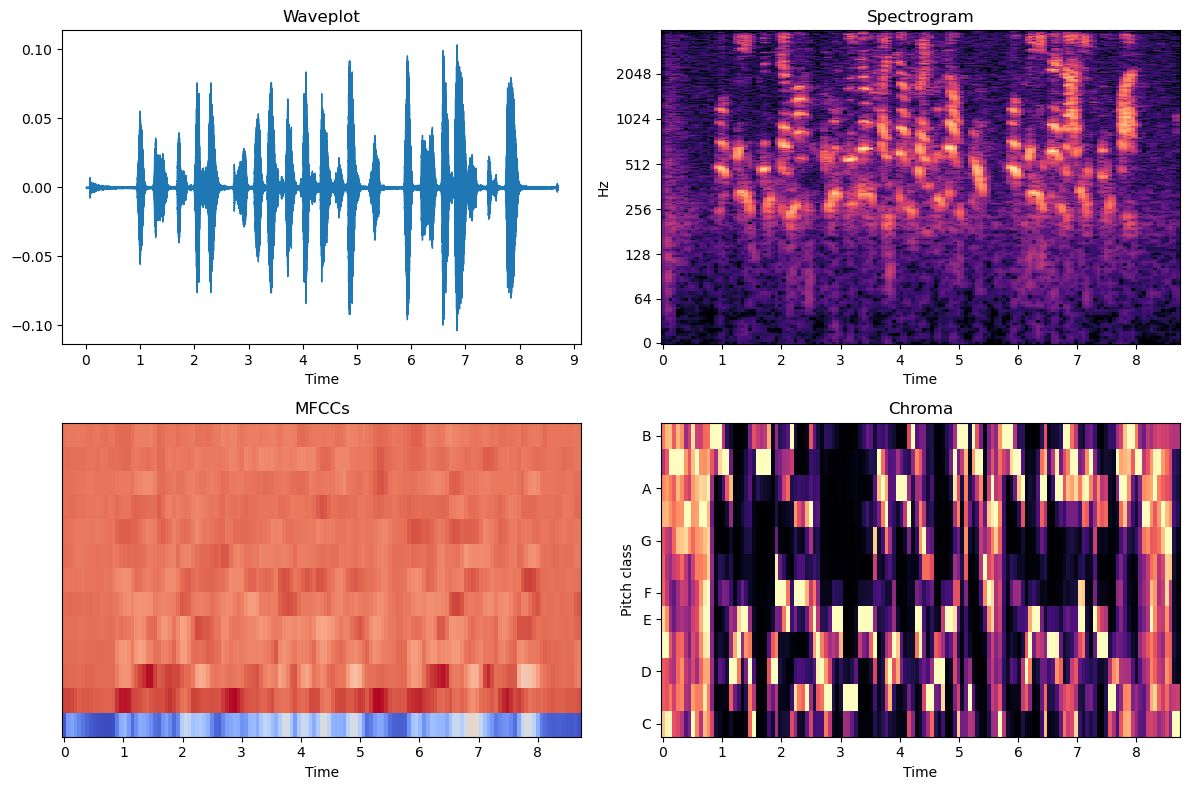

In [ ]:
# Convert audio array to float32
chinese_audio = chinese_audio.astype(np.float32)

# Compute MFCCs and Chroma
mfccs = librosa.feature.mfcc(y=chinese_audio, sr=chinese_sampling_rate, n_mfcc=13)
chroma = librosa.feature.chroma_stft(y=chinese_audio, sr=chinese_sampling_rate)

# Plot Waveplot
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
librosa.display.waveshow(chinese_audio, sr=chinese_sampling_rate)
plt.title('Waveplot')

# Plot Spectrogram
plt.subplot(2, 2, 2)
D = librosa.amplitude_to_db(np.abs(librosa.stft(chinese_audio)), ref=np.max)
librosa.display.specshow(D, sr=chinese_sampling_rate, x_axis='time', y_axis='log')
plt.title('Spectrogram')

# Plot MFCCs
plt.subplot(2, 2, 3)
librosa.display.specshow(mfccs, sr=chinese_sampling_rate, x_axis='time')
plt.title('MFCCs')

# Plot Chroma
plt.subplot(2, 2, 4)
librosa.display.specshow(chroma, sr=chinese_sampling_rate, x_axis='time', y_axis='chroma')
plt.title('Chroma')

plt.tight_layout()
plt.show()

In [ ]:
# cek audio
audio_player_chinese = Audio(data=chinese_audio, rate=chinese_sampling_rate)
display(audio_player_chinese)

## Russian Audio

In [ ]:
# pakai data train
split = 'train'

# lang_id = 12 yaitu Rusia
russian_dataset = dataset[split].filter(lambda example: example['lang_id'] == 12)

# cek sampling rate dan audio array
russian_audio = russian_dataset[0]['audio']['array']
russian_sampling_rate = russian_dataset[0]['audio']['sampling_rate']

# sanity check
print(f"Audio array shape: {len(russian_audio)} samples")
print(f"Sampling rate: {russian_sampling_rate}")

Filter:   0%|          | 0/1652 [00:00<?, ? examples/s]

Audio array shape: 24520 samples
Sampling rate: 8000


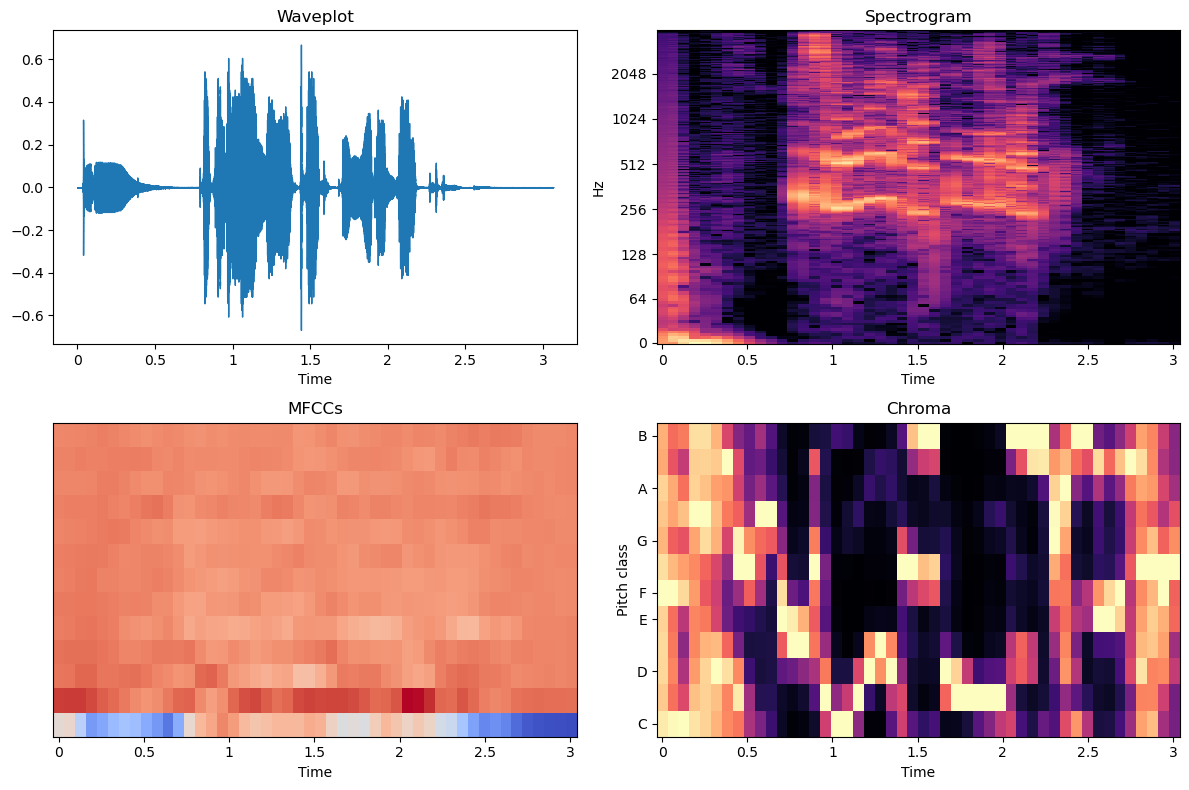

In [ ]:
# Convert audio array to float32
russian_audio = russian_audio.astype(np.float32)

# Compute MFCCs and Chroma
mfccs = librosa.feature.mfcc(y=russian_audio, sr=russian_sampling_rate, n_mfcc=13)
chroma = librosa.feature.chroma_stft(y=russian_audio, sr=russian_sampling_rate)

# Plot Waveplot
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
librosa.display.waveshow(russian_audio, sr=russian_sampling_rate)
plt.title('Waveplot')

# Plot Spectrogram
plt.subplot(2, 2, 2)
D = librosa.amplitude_to_db(np.abs(librosa.stft(russian_audio)), ref=np.max)
librosa.display.specshow(D, sr=russian_sampling_rate, x_axis='time', y_axis='log')
plt.title('Spectrogram')

# Plot MFCCs
plt.subplot(2, 2, 3)
librosa.display.specshow(mfccs, sr=russian_sampling_rate, x_axis='time')
plt.title('MFCCs')

# Plot Chroma
plt.subplot(2, 2, 4)
librosa.display.specshow(chroma, sr=russian_sampling_rate, x_axis='time', y_axis='chroma')
plt.title('Chroma')

plt.tight_layout()
plt.show()

In [ ]:
# cek audio
audio_player_russian = Audio(data=russian_audio, rate=russian_sampling_rate)
display(audio_player_russian)

## French Audio

In [ ]:
# pakai data train
split = 'train'

# lang_id = 6 yaitu Prancis
french_dataset = dataset[split].filter(lambda example: example['lang_id'] == 6)

# cek sampling rate dan audio array
french_audio = french_dataset[0]['audio']['array']
french_sampling_rate = french_dataset[0]['audio']['sampling_rate']

# sanity check
print(f"Audio array shape: {len(french_audio)} samples")
print(f"Sampling rate: {french_sampling_rate}")

Filter:   0%|          | 0/1652 [00:00<?, ? examples/s]

Audio array shape: 28331 samples
Sampling rate: 8000


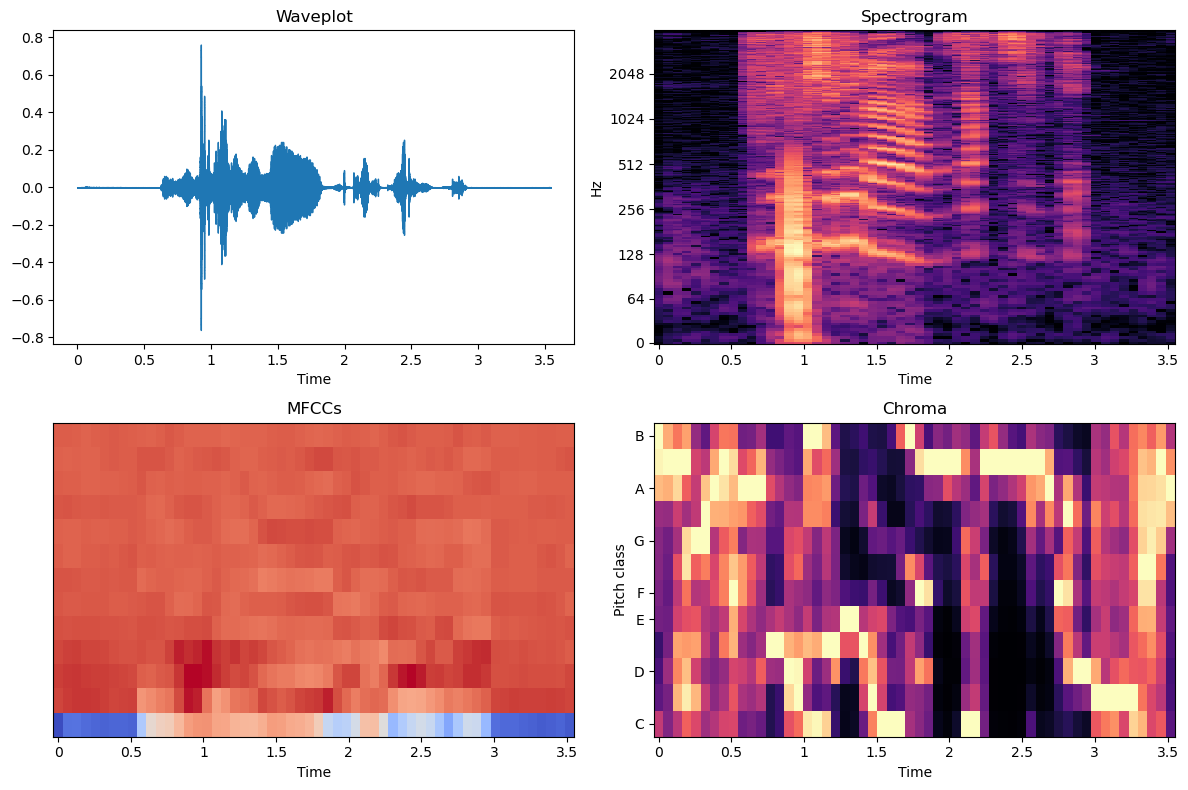

In [ ]:
# Convert audio array to float32
french_audio = french_audio.astype(np.float32)

# Compute MFCCs and Chroma
mfccs = librosa.feature.mfcc(y=french_audio, sr=french_sampling_rate, n_mfcc=13)
chroma = librosa.feature.chroma_stft(y=french_audio, sr=french_sampling_rate)

# Plot Waveplot
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
librosa.display.waveshow(french_audio, sr=french_sampling_rate)
plt.title('Waveplot')

# Plot Spectrogram
plt.subplot(2, 2, 2)
D = librosa.amplitude_to_db(np.abs(librosa.stft(french_audio)), ref=np.max)
librosa.display.specshow(D, sr=french_sampling_rate, x_axis='time', y_axis='log')
plt.title('Spectrogram')

# Plot MFCCs
plt.subplot(2, 2, 3)
librosa.display.specshow(mfccs, sr=french_sampling_rate, x_axis='time')
plt.title('MFCCs')

# Plot Chroma
plt.subplot(2, 2, 4)
librosa.display.specshow(chroma, sr=french_sampling_rate, x_axis='time', y_axis='chroma')
plt.title('Chroma')

plt.tight_layout()
plt.show()

In [ ]:
# cek audio
audio_player_french = Audio(data=french_audio, rate=french_sampling_rate)
display(audio_player_french)

## English Audio

In [ ]:
# pakai data train
split = 'train'

# lang_id = 4 yaitu US
english_dataset = dataset[split].filter(lambda example: example['lang_id'] == 4)

# cek sampling rate dan audio array
english_audio = english_dataset[0]['audio']['array']
english_sampling_rate = english_dataset[0]['audio']['sampling_rate']

# sanity check
print(f"Audio array shape: {len(english_audio)} samples")
print(f"Sampling rate: {english_sampling_rate}")

Filter:   0%|          | 0/1652 [00:00<?, ? examples/s]

Audio array shape: 73561 samples
Sampling rate: 8000


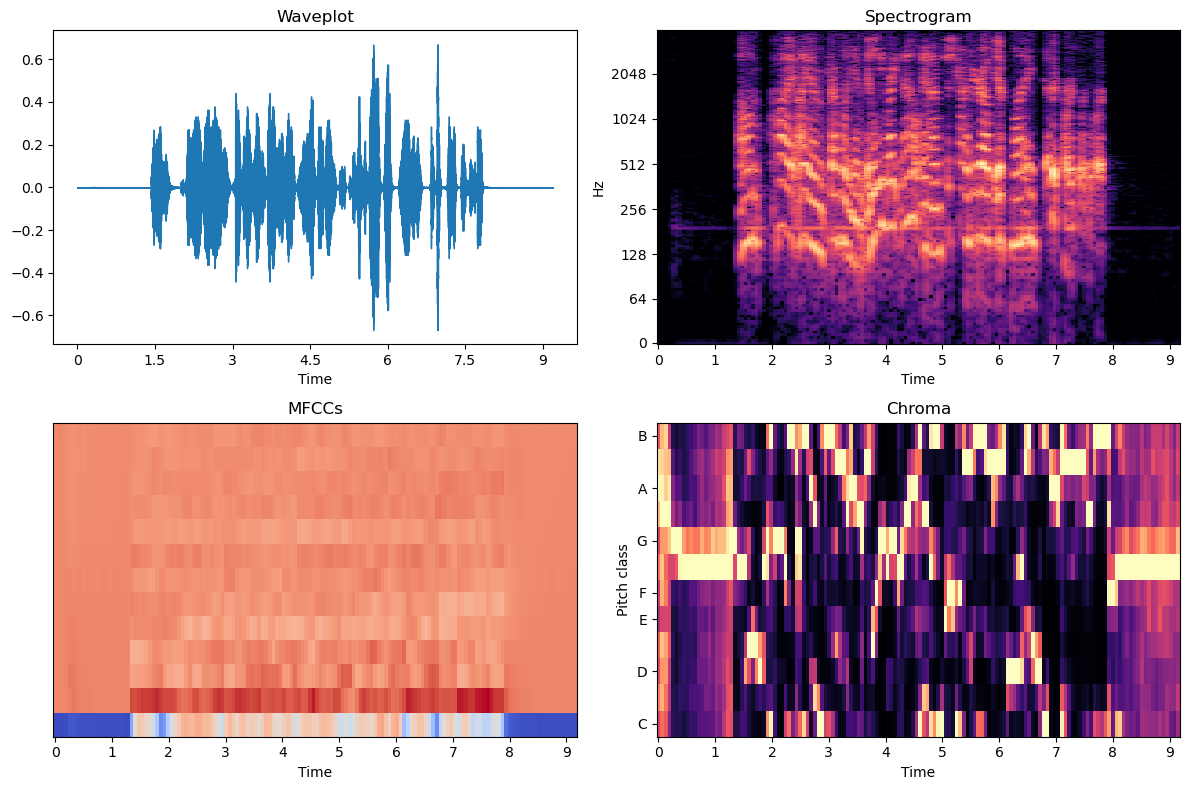

In [ ]:
# Convert audio array to float32
english_audio = english_audio.astype(np.float32)

# Compute MFCCs and Chroma
mfccs = librosa.feature.mfcc(y=english_audio, sr=english_sampling_rate, n_mfcc=13)
chroma = librosa.feature.chroma_stft(y=english_audio, sr=english_sampling_rate)

# Plot Waveplot
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
librosa.display.waveshow(english_audio, sr=english_sampling_rate)
plt.title('Waveplot')

# Plot Spectrogram
plt.subplot(2, 2, 2)
D = librosa.amplitude_to_db(np.abs(librosa.stft(english_audio)), ref=np.max)
librosa.display.specshow(D, sr=english_sampling_rate, x_axis='time', y_axis='log')
plt.title('Spectrogram')

# Plot MFCCs
plt.subplot(2, 2, 3)
librosa.display.specshow(mfccs, sr=english_sampling_rate, x_axis='time')
plt.title('MFCCs')

# Plot Chroma
plt.subplot(2, 2, 4)
librosa.display.specshow(chroma, sr=english_sampling_rate, x_axis='time', y_axis='chroma')
plt.title('Chroma')

plt.tight_layout()
plt.show()

In [ ]:
# cek audio
audio_player_english = Audio(data=english_audio, rate=english_sampling_rate)
display(audio_player_english)

## German Audio

In [ ]:
# pakai data train
split = 'train'

# lang_id = 1 yaitu german
german_dataset = dataset[split].filter(lambda example: example['lang_id'] == 1) 

# cek sampling rate dan audio array
german_audio = german_dataset[0]['audio']['array']
german_sampling_rate = german_dataset[0]['audio']['sampling_rate']

# sanity check
print(f"Audio array shape: {len(german_audio)} samples")
print(f"Sampling rate: {german_sampling_rate}")

Filter:   0%|          | 0/1652 [00:00<?, ? examples/s]

Audio array shape: 106880 samples
Sampling rate: 8000


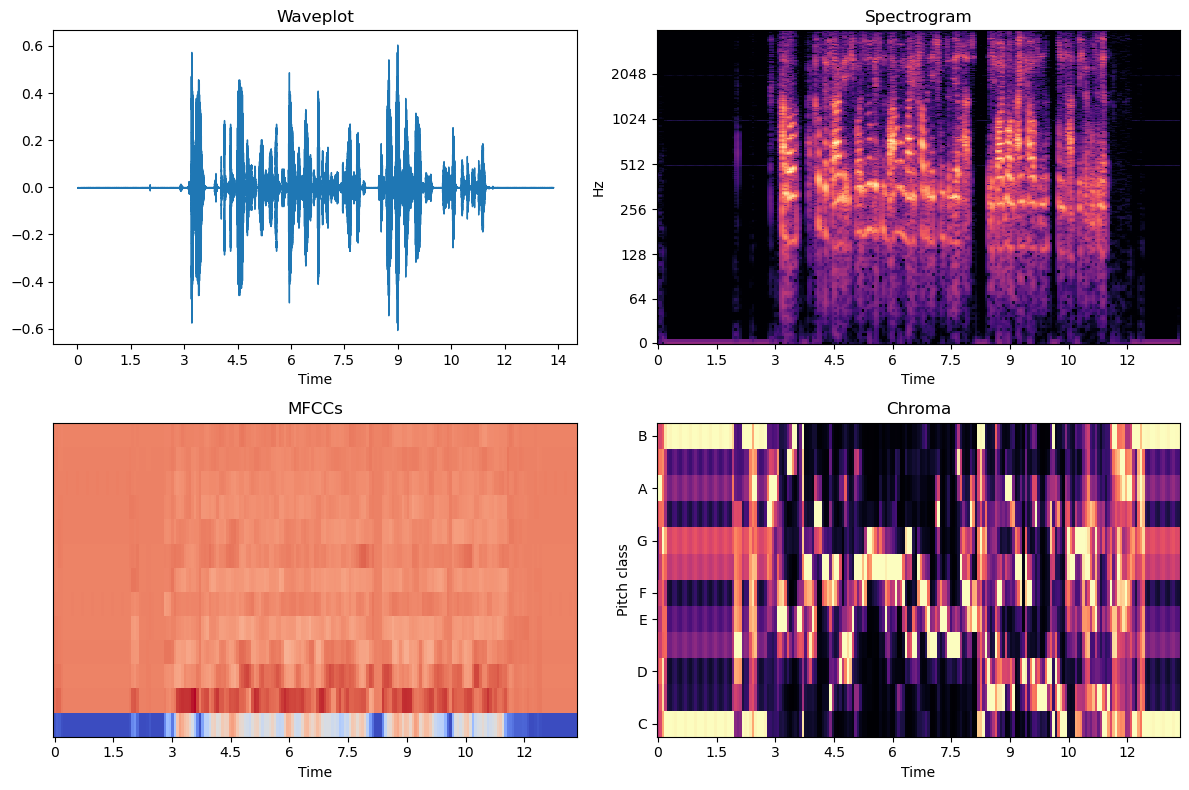

In [ ]:
# Convert audio array to float32
german_audio = german_audio.astype(np.float32)

# Compute MFCCs and Chroma
mfccs = librosa.feature.mfcc(y=german_audio, sr=german_sampling_rate, n_mfcc=13)
chroma = librosa.feature.chroma_stft(y=german_audio, sr=german_sampling_rate)

# Plot Waveplot
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
librosa.display.waveshow(german_audio, sr=german_sampling_rate)
plt.title('Waveplot')

# Plot Spectrogram
plt.subplot(2, 2, 2)
D = librosa.amplitude_to_db(np.abs(librosa.stft(german_audio)), ref=np.max)
librosa.display.specshow(D, sr=german_sampling_rate, x_axis='time', y_axis='log')
plt.title('Spectrogram')

# Plot MFCCs
plt.subplot(2, 2, 3)
librosa.display.specshow(mfccs, sr=german_sampling_rate, x_axis='time')
plt.title('MFCCs')

# Plot Chroma
plt.subplot(2, 2, 4)
librosa.display.specshow(chroma, sr=german_sampling_rate, x_axis='time', y_axis='chroma')
plt.title('Chroma')

plt.tight_layout()
plt.show()

In [ ]:
# cek audio
audio_player_german = Audio(data=german_audio, rate=german_sampling_rate)
display(audio_player_german)

In [ ]:
!pip install WordCloud

   ---------------------------------------- 0.0/301.4 kB ? eta -:--:--
   ---------------------------------------- 0.0/301.4 kB ? eta -:--:--
   - -------------------------------------- 10.2/301.4 kB ? eta -:--:--
   --- ----------------------------------- 30.7/301.4 kB 435.7 kB/s eta 0:00:01
   ------- ------------------------------- 61.4/301.4 kB 544.7 kB/s eta 0:00:01
   -------------------------------- ------- 245.8/301.4 kB 1.7 MB/s eta 0:00:01
   ---------------------------------------- 301.4/301.4 kB 1.7 MB/s eta 0:00:00


In [ ]:
# Proses menjadikan dataframe menggunakan data train
intent_class_labels = dataset['train'].features['intent_class'].names
language_labels = dataset['train'].features['lang_id'].names

def process_example(example):
    audio_id = os.path.basename(example['path'])
    return {
        'audio_id': audio_id,
        'len_audio_array': len(example['audio']['array']),
        'audio_sampling_rate': example['audio']['sampling_rate'],
        'transcription': example['transcription'],
        'en_transcription': example['english_transcription'],
        'intent_class': example['intent_class'],
        'intent_class_name': intent_class_labels[example['intent_class']],
        'lang_id': example['lang_id'],
        'language': language_labels[example['lang_id']]
    }

train_data = dataset['train'].map(process_example)
train_df = pd.DataFrame(train_data)

# Sanity Check
train_df

Map:   0%|          | 0/1652 [00:00<?, ? examples/s]

,path,audio,transcription,english_transcription,intent_class,lang_id,audio_id,len_audio_array,audio_sampling_rate,en_transcription,intent_class_name,language
0,C:\Users\andip\.cache\huggingface\datasets\dow...,"{'path': None, 'array': [0.000244140625, 0.000...",Hallo kurze frage ich wollte nur wissen warum ...,Hello short question I just wanted to know why...,6,1,CA3ee78582d721d7ac7c06a3dd33b035f8_0.wav,106880,8000,Hello short question I just wanted to know why...,card_issues,de-DE
1,C:\Users\andip\.cache\huggingface\datasets\dow...,"{'path': None, 'array': [-0.000244140625, 0.0,...",hi I am traveling in Italy right now and I'm j...,hi I am traveling in Italy right now and I'm j...,0,4,602ba3f25f67b421554f63ea.wav,73561,8000,hi I am traveling in Italy right now and I'm j...,abroad,en-US
2,C:\Users\andip\.cache\huggingface\datasets\dow...,"{'path': None, 'array': [0.000244140625, 0.000...",nein noch nicht,no not yet,0,1,CA3d0f605843bacd4a7cf30edf28db3bb4_3.wav,29600,8000,no not yet,abroad,de-DE
3,C:\Users\andip\.cache\huggingface\datasets\dow...,"{'path': None, 'array': [0.0, 0.0, 0.0, 0.0, 0...",Почему моя карта не работает,Why is my card not working,6,12,60301d9e963e11ccd901e9f7.wav,24520,8000,Why is my card not working,card_issues,ru-RU
4,C:\Users\andip\.cache\huggingface\datasets\dow...,"{'path': None, 'array': [0.000244140625, 0.0, ...",я получила эсэмэску потому что пытаюсь заплати...,I received a text message because I am trying ...,10,12,60300a375f67b421554f7100.wav,59443,8000,I received a text message because I am trying ...,high_value_payment,ru-RU
...,...,...,...,...,...,...,...,...,...,...,...,...
1647,C:\Users\andip\.cache\huggingface\datasets\dow...,"{'path': None, 'array': [-0.000732421875, -0.0...",ich habe meine Karte verloren und möchte sie s...,I have lost my card and would like to have it ...,9,1,CA18c354b127c0b25c7a4289a82284c5fa_2.wav,56320,8000,I have lost my card and would like to have it ...,freeze,de-DE
1648,C:\Users\andip\.cache\huggingface\datasets\dow...,"{'path': None, 'array': [0.0, 0.0, 0.0, 0.0, 0...",Здравствуйте мне хотелось бы узнать по поводу ...,"Hello, I would like to inquire about a busines...",5,12,60300b0bbb1e6d0fbce93b08.wav,178329,8000,"Hello, I would like to inquire about a busines...",business_loan,ru-RU
1649,C:\Users\andip\.cache\huggingface\datasets\dow...,"{'path': None, 'array': [0.0, 0.000244140625, ...",你好我现在遇到一个问题他在说该应用无法加载请问需要如何处理,"Hello, I have a problem now. He is saying that...",2,13,6035369e4c449c80694dc50f.wav,74411,8000,"Hello, I have a problem now. He is saying that...",app_error,zh-CN
1650,C:\Users\andip\.cache\huggingface\datasets\dow...,"{'path': None, 'array': [0.0, 0.0, 0.0, 0.0, 0...",Здравствуйте у меня дебетовая карта вашего бан...,"Hello, I have a debit card of your bank, I am ...",0,12,6030074c05f96973d67950d2.wav,105131,8000,"Hello, I have a debit card of your bank, I am ...",abroad,ru-RU


In [ ]:
import os
import json
import pprint
import re
import pickle
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
from wordcloud import WordCloud
import json

import nltk
from collections import Counter
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from nltk import ngrams
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import nltk

# Pastikan Anda telah mengunduh daftar stopwords dari NLTK
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\andip\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andip\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
train_df

,path,audio,transcription,english_transcription,intent_class,lang_id,audio_id,len_audio_array,audio_sampling_rate,en_transcription,intent_class_name,language
0,C:\Users\andip\.cache\huggingface\datasets\dow...,"{'path': None, 'array': [0.000244140625, 0.000...",Hallo kurze frage ich wollte nur wissen warum ...,Hello short question I just wanted to know why...,6,1,CA3ee78582d721d7ac7c06a3dd33b035f8_0.wav,106880,8000,Hello short question I just wanted to know why...,card_issues,de-DE
1,C:\Users\andip\.cache\huggingface\datasets\dow...,"{'path': None, 'array': [-0.000244140625, 0.0,...",hi I am traveling in Italy right now and I'm j...,hi I am traveling in Italy right now and I'm j...,0,4,602ba3f25f67b421554f63ea.wav,73561,8000,hi I am traveling in Italy right now and I'm j...,abroad,en-US
2,C:\Users\andip\.cache\huggingface\datasets\dow...,"{'path': None, 'array': [0.000244140625, 0.000...",nein noch nicht,no not yet,0,1,CA3d0f605843bacd4a7cf30edf28db3bb4_3.wav,29600,8000,no not yet,abroad,de-DE
3,C:\Users\andip\.cache\huggingface\datasets\dow...,"{'path': None, 'array': [0.0, 0.0, 0.0, 0.0, 0...",Почему моя карта не работает,Why is my card not working,6,12,60301d9e963e11ccd901e9f7.wav,24520,8000,Why is my card not working,card_issues,ru-RU
4,C:\Users\andip\.cache\huggingface\datasets\dow...,"{'path': None, 'array': [0.000244140625, 0.0, ...",я получила эсэмэску потому что пытаюсь заплати...,I received a text message because I am trying ...,10,12,60300a375f67b421554f7100.wav,59443,8000,I received a text message because I am trying ...,high_value_payment,ru-RU
...,...,...,...,...,...,...,...,...,...,...,...,...
1647,C:\Users\andip\.cache\huggingface\datasets\dow...,"{'path': None, 'array': [-0.000732421875, -0.0...",ich habe meine Karte verloren und möchte sie s...,I have lost my card and would like to have it ...,9,1,CA18c354b127c0b25c7a4289a82284c5fa_2.wav,56320,8000,I have lost my card and would like to have it ...,freeze,de-DE
1648,C:\Users\andip\.cache\huggingface\datasets\dow...,"{'path': None, 'array': [0.0, 0.0, 0.0, 0.0, 0...",Здравствуйте мне хотелось бы узнать по поводу ...,"Hello, I would like to inquire about a busines...",5,12,60300b0bbb1e6d0fbce93b08.wav,178329,8000,"Hello, I would like to inquire about a busines...",business_loan,ru-RU
1649,C:\Users\andip\.cache\huggingface\datasets\dow...,"{'path': None, 'array': [0.0, 0.000244140625, ...",你好我现在遇到一个问题他在说该应用无法加载请问需要如何处理,"Hello, I have a problem now. He is saying that...",2,13,6035369e4c449c80694dc50f.wav,74411,8000,"Hello, I have a problem now. He is saying that...",app_error,zh-CN
1650,C:\Users\andip\.cache\huggingface\datasets\dow...,"{'path': None, 'array': [0.0, 0.0, 0.0, 0.0, 0...",Здравствуйте у меня дебетовая карта вашего бан...,"Hello, I have a debit card of your bank, I am ...",0,12,6030074c05f96973d67950d2.wav,105131,8000,"Hello, I have a debit card of your bank, I am ...",abroad,ru-RU


## Audio Lengths Distribution

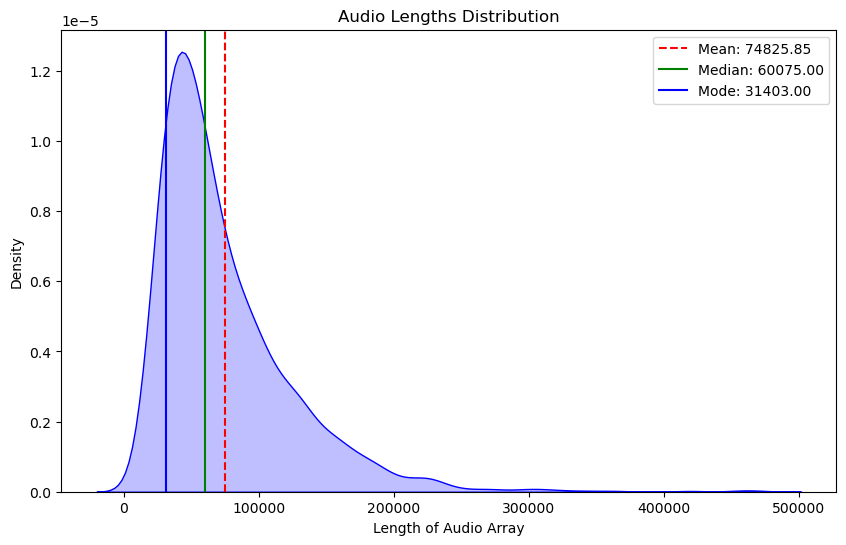

In [ ]:
# Membuat KDE Plot dengan Central Tendency kolom len_audio_array
mean_len = train_df['len_audio_array'].mean()
median_len = train_df['len_audio_array'].median()
mode_len = train_df['len_audio_array'].mode()[0]

plt.figure(figsize=(10, 6))
sns.kdeplot(train_df['len_audio_array'], shade=True, color="blue")

plt.axvline(mean_len, color='r', linestyle='--', label=f'Mean: {mean_len:.2f}')
plt.axvline(median_len, color='g', linestyle='-', label=f'Median: {median_len:.2f}')
plt.axvline(mode_len, color='b', linestyle='-', label=f'Mode: {mode_len:.2f}')

plt.xlabel('Length of Audio Array')
plt.ylabel('Density')
plt.title('Audio Lengths Distribution')
plt.legend()
plt.show()


## Distribution of English Transcription Lengths

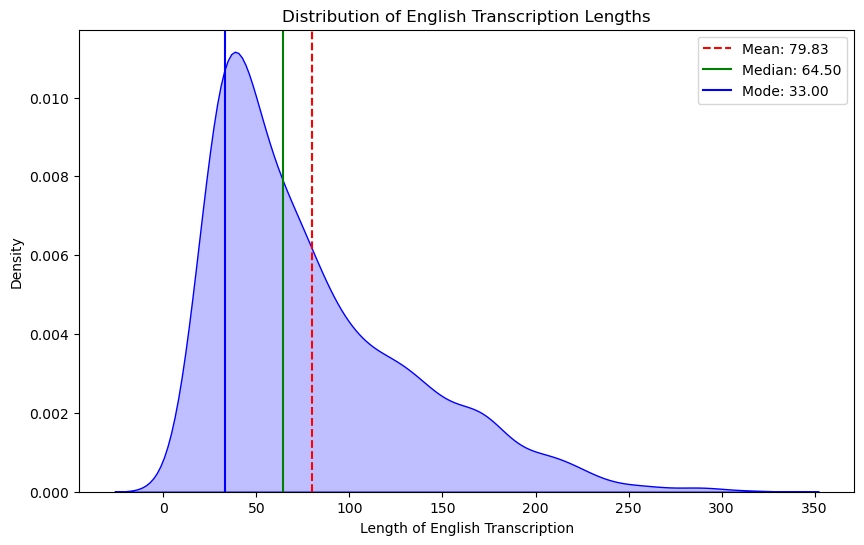

In [ ]:
# Membuat KDE Plot dengan Central Tendency kolom en_transcription
train_df['en_transcription_length'] = train_df['en_transcription'].apply(len)

mean_len = train_df['en_transcription_length'].mean()
median_len = train_df['en_transcription_length'].median()
mode_len = train_df['en_transcription_length'].mode()[0]

plt.figure(figsize=(10, 6))
sns.kdeplot(train_df['en_transcription_length'], shade=True, color="blue")

plt.axvline(mean_len, color='r', linestyle='--', label=f'Mean: {mean_len:.2f}')
plt.axvline(median_len, color='g', linestyle='-', label=f'Median: {median_len:.2f}')
plt.axvline(mode_len, color='b', linestyle='-', label=f'Mode: {mode_len:.2f}')

plt.xlabel('Length of English Transcription')
plt.ylabel('Density')
plt.title('Distribution of English Transcription Lengths')
plt.legend()
plt.show()


In [ ]:
train_df['audio_sampling_rate'].value_counts()

audio_sampling_rate
8000    1652
Name: count, dtype: int64

## Distribution of Intent Classes

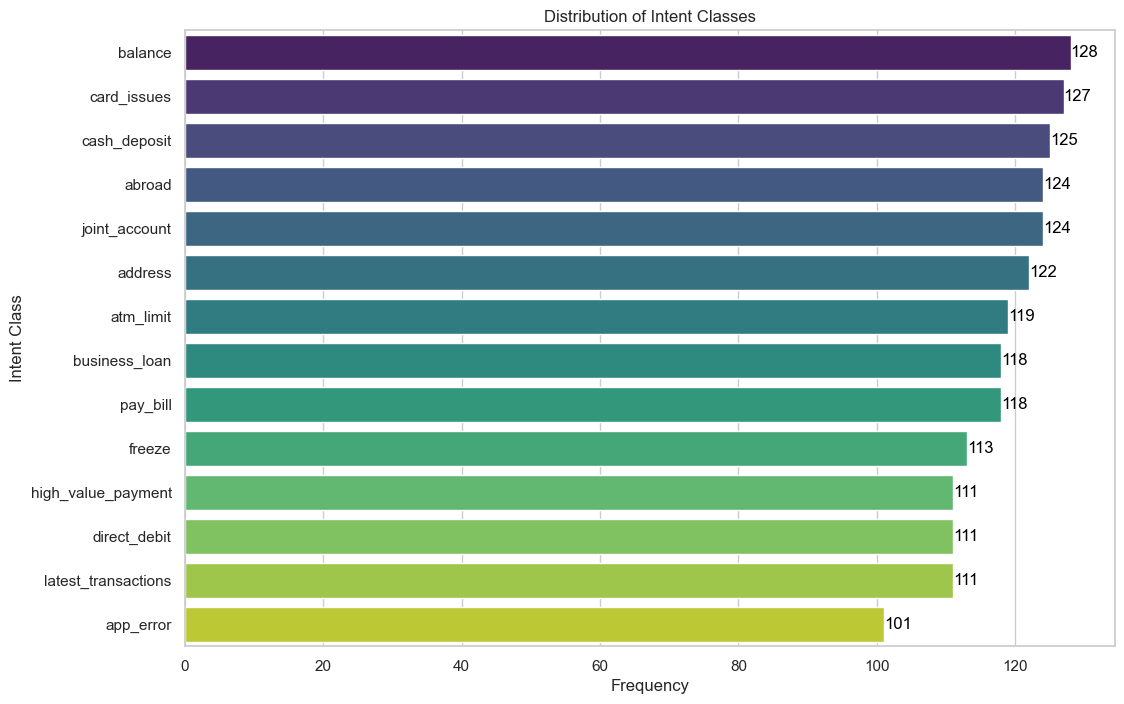

In [ ]:
# Membuat Distribution of Intent Classes
sns.set(style="whitegrid")

intent_counts = train_df['intent_class_name'].value_counts().reset_index()
intent_counts.columns = ['Intent Class', 'Frequency']

plt.figure(figsize=(12, 8))
ax = sns.barplot(x='Frequency', y='Intent Class', data=intent_counts, palette='viridis')

for index, value in enumerate(intent_counts['Frequency']):
    ax.text(value, index, f'{value}', color='black', ha="left", va="center")

plt.xlabel('Frequency')
plt.ylabel('Intent Class')
plt.title('Distribution of Intent Classes')
plt.show()


## Distribution of Languages

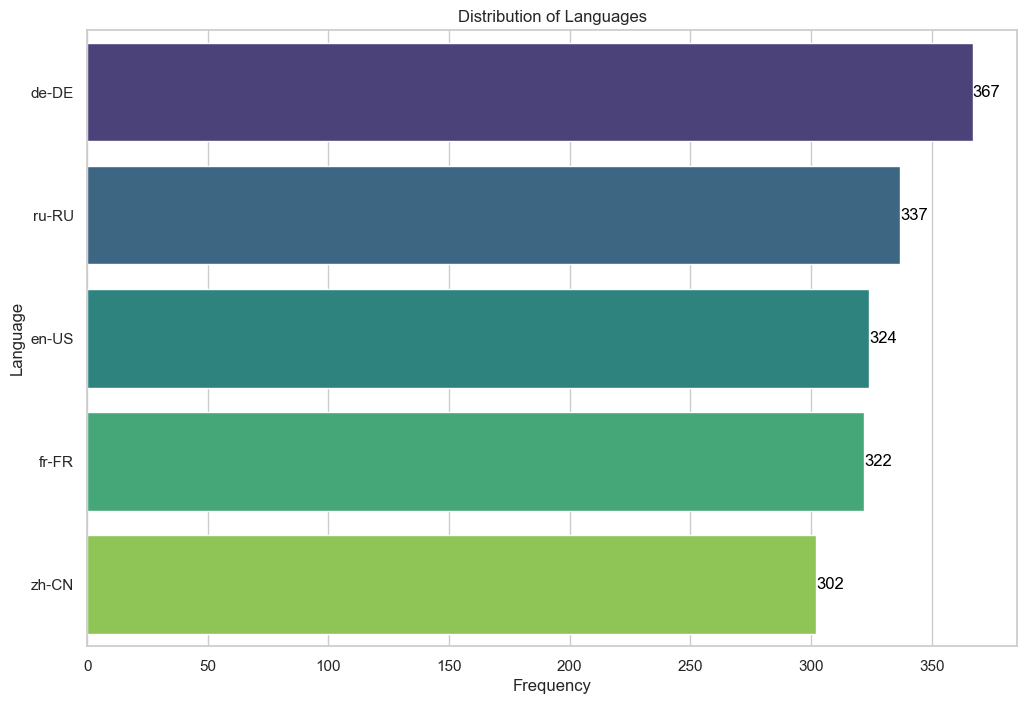

In [ ]:
# Membuat Distribution of language 
sns.set(style="whitegrid")

language_counts = train_df['language'].value_counts().reset_index()
language_counts.columns = ['Language', 'Frequency']

plt.figure(figsize=(12, 8))
ax = sns.barplot(x='Frequency', y='Language', data=language_counts, palette='viridis')

for index, value in enumerate(language_counts['Frequency']):
    ax.text(value, index, f'{value}', color='black', ha="left", va="center")

plt.xlabel('Frequency')
plt.ylabel('Language')
plt.title('Distribution of Languages')
plt.show()


In [ ]:
# Pola regex untuk tanda baca
punctuation_pattern = r'[^\w\s@]'

# Mengambil baris yang mengandung tanda baca di kolom 'en_transcription'
rows_with_punctuation = train_df[train_df['en_transcription'].str.contains(punctuation_pattern, regex=True)]

# Ekstraksi tanda baca
def extract_punctuation(teks):
    punctuations = re.findall(punctuation_pattern, teks)
    return ', '.join(punctuations) if punctuations else None

# Menambahkan kolom 'punctuations' ke DataFrame
rows_with_punctuation['punctuations'] = rows_with_punctuation['en_transcription'].apply(extract_punctuation)

rows_with_punctuation

,path,audio,transcription,english_transcription,intent_class,lang_id,audio_id,len_audio_array,audio_sampling_rate,en_transcription,intent_class_name,language,en_transcription_length,punctuations
1,C:\Users\andip\.cache\huggingface\datasets\dow...,"{'path': None, 'array': [-0.000244140625, 0.0,...",hi I am traveling in Italy right now and I'm j...,hi I am traveling in Italy right now and I'm j...,0,4,602ba3f25f67b421554f63ea.wav,73561,8000,hi I am traveling in Italy right now and I'm j...,abroad,en-US,76,'
5,C:\Users\andip\.cache\huggingface\datasets\dow...,"{'path': None, 'array': [0.0, 0.0, 0.0, 0.0, 0...",your mobile app isn't working,your mobile app isn't working,2,4,602babd2bb1e6d0fbce921b4.wav,53248,8000,your mobile app isn't working,app_error,en-US,29,'
7,C:\Users\andip\.cache\huggingface\datasets\dow...,"{'path': None, 'array': [0.0, 0.0, -0.00024414...",我可以存钱吗如何将款项转入账户我可以在哪里同款,Can I deposit money? How can I transfer money ...,7,13,60352bdd4c449c80694dc47b.wav,69632,8000,Can I deposit money? How can I transfer money ...,cash_deposit,zh-CN,93,"?, ?, ?"
9,C:\Users\andip\.cache\huggingface\datasets\dow...,"{'path': None, 'array': [0.000244140625, 0.0, ...",Добрый день У меня возникла проблема Я пытаюсь...,Good afternoon I have a problem I am trying to...,10,12,60301843bb1e6d0fbce93d34.wav,91477,8000,Good afternoon I have a problem I am trying to...,high_value_payment,ru-RU,147,","
10,C:\Users\andip\.cache\huggingface\datasets\dow...,"{'path': None, 'array': [0.0, 0.0, 0.0, 0.0, 0...",I've been using this app for taxes my bank acc...,I've been using this app for taxes my bank acc...,2,4,602ba3bcbb1e6d0fbce92023.wav,94891,8000,I've been using this app for taxes my bank acc...,app_error,en-US,119,"', '"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1641,C:\Users\andip\.cache\huggingface\datasets\dow...,"{'path': None, 'array': [0.00048828125, 0.0004...",Hallo meinte gerne dass Sie die Transaktion au...,"Hello, I meant that you would please stop the ...",9,1,CA52e1791b54c55ad6b98c2c1f5bf2bf61_0.wav,99840,8000,"Hello, I meant that you would please stop the ...",freeze,de-DE,68,","
1643,C:\Users\andip\.cache\huggingface\datasets\dow...,"{'path': None, 'array': [0.0, -0.000244140625,...",Hallo ich würde gerne Geld am Geldautomaten ab...,"Hello, I would like to withdraw money from the...",3,1,CA90fa7a650fc846895022442d06afa397_0.wav,92480,8000,"Hello, I would like to withdraw money from the...",atm_limit,de-DE,116,","
1648,C:\Users\andip\.cache\huggingface\datasets\dow...,"{'path': None, 'array': [0.0, 0.0, 0.0, 0.0, 0...",Здравствуйте мне хотелось бы узнать по поводу ...,"Hello, I would like to inquire about a busines...",5,12,60300b0bbb1e6d0fbce93b08.wav,178329,8000,"Hello, I would like to inquire about a busines...",business_loan,ru-RU,84,","
1649,C:\Users\andip\.cache\huggingface\datasets\dow...,"{'path': None, 'array': [0.0, 0.000244140625, ...",你好我现在遇到一个问题他在说该应用无法加载请问需要如何处理,"Hello, I have a problem now. He is saying that...",2,13,6035369e4c449c80694dc50f.wav,74411,8000,"Hello, I have a problem now. He is saying that...",app_error,zh-CN,98,",, ., ., ?"


In [ ]:
# Pola regex untuk karakter non-alfanumerik
non_alnum_pattern = r'\W+'

# Mengambil baris yang mengandung karakter non-alfanumerik di kolom 'en_transcription'
rows_with_non_alnum = train_df[train_df['en_transcription'].str.contains(non_alnum_pattern, regex=True)]

# Ekstraksi karakter non-alfanumerik
def extract_non_alnum(teks):
    non_alnums = re.findall(non_alnum_pattern, teks)
    return ', '.join(non_alnums) if non_alnums else None

# Menambahkan kolom 'non_alphanumeric' ke DataFrame
rows_with_non_alnum['non_alphanumeric'] = rows_with_non_alnum['en_transcription'].apply(extract_non_alnum)

rows_with_non_alnum


,path,audio,transcription,english_transcription,intent_class,lang_id,audio_id,len_audio_array,audio_sampling_rate,en_transcription,intent_class_name,language,en_transcription_length,non_alphanumeric
0,C:\Users\andip\.cache\huggingface\datasets\dow...,"{'path': None, 'array': [0.000244140625, 0.000...",Hallo kurze frage ich wollte nur wissen warum ...,Hello short question I just wanted to know why...,6,1,CA3ee78582d721d7ac7c06a3dd33b035f8_0.wav,106880,8000,Hello short question I just wanted to know why...,card_issues,de-DE,124,", , , , , , , , , , , , , , , ..."
1,C:\Users\andip\.cache\huggingface\datasets\dow...,"{'path': None, 'array': [-0.000244140625, 0.0,...",hi I am traveling in Italy right now and I'm j...,hi I am traveling in Italy right now and I'm j...,0,4,602ba3f25f67b421554f63ea.wav,73561,8000,hi I am traveling in Italy right now and I'm j...,abroad,en-US,76,", , , , , , , , , ', , , , , , ,"
2,C:\Users\andip\.cache\huggingface\datasets\dow...,"{'path': None, 'array': [0.000244140625, 0.000...",nein noch nicht,no not yet,0,1,CA3d0f605843bacd4a7cf30edf28db3bb4_3.wav,29600,8000,no not yet,abroad,de-DE,10,","
3,C:\Users\andip\.cache\huggingface\datasets\dow...,"{'path': None, 'array': [0.0, 0.0, 0.0, 0.0, 0...",Почему моя карта не работает,Why is my card not working,6,12,60301d9e963e11ccd901e9f7.wav,24520,8000,Why is my card not working,card_issues,ru-RU,26,", , , ,"
4,C:\Users\andip\.cache\huggingface\datasets\dow...,"{'path': None, 'array': [0.000244140625, 0.0, ...",я получила эсэмэску потому что пытаюсь заплати...,I received a text message because I am trying ...,10,12,60300a375f67b421554f7100.wav,59443,8000,I received a text message because I am trying ...,high_value_payment,ru-RU,67,", , , , , , , , , , , ,"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1647,C:\Users\andip\.cache\huggingface\datasets\dow...,"{'path': None, 'array': [-0.000732421875, -0.0...",ich habe meine Karte verloren und möchte sie s...,I have lost my card and would like to have it ...,9,1,CA18c354b127c0b25c7a4289a82284c5fa_2.wav,56320,8000,I have lost my card and would like to have it ...,freeze,de-DE,53,", , , , , , , , , ,"
1648,C:\Users\andip\.cache\huggingface\datasets\dow...,"{'path': None, 'array': [0.0, 0.0, 0.0, 0.0, 0...",Здравствуйте мне хотелось бы узнать по поводу ...,"Hello, I would like to inquire about a busines...",5,12,60300b0bbb1e6d0fbce93b08.wav,178329,8000,"Hello, I would like to inquire about a busines...",business_loan,ru-RU,84,", , , , , , , , , , , , , , , ,"
1649,C:\Users\andip\.cache\huggingface\datasets\dow...,"{'path': None, 'array': [0.0, 0.000244140625, ...",你好我现在遇到一个问题他在说该应用无法加载请问需要如何处理,"Hello, I have a problem now. He is saying that...",2,13,6035369e4c449c80694dc50f.wav,74411,8000,"Hello, I have a problem now. He is saying that...",app_error,zh-CN,98,", , , , , , . , , , , , , , , , . ..."
1650,C:\Users\andip\.cache\huggingface\datasets\dow...,"{'path': None, 'array': [0.0, 0.0, 0.0, 0.0, 0...",Здравствуйте у меня дебетовая карта вашего бан...,"Hello, I have a debit card of your bank, I am ...",0,12,6030074c05f96973d67950d2.wav,105131,8000,"Hello, I have a debit card of your bank, I am ...",abroad,ru-RU,165,", , , , , , , , , , , , , , , , . ..."


In [ ]:
# Pola regex untuk karakter khusus
special_char_pattern = r'[^a-zA-Z0-9\s]'

# Mengambil baris yang mengandung karakter khusus di kolom 'en_transcription'
rows_with_special_char = train_df[train_df['en_transcription'].str.contains(special_char_pattern, regex=True)]

# Ekstraksi karakter khusus
def extract_special_char(teks):
    special_chars = re.findall(special_char_pattern, teks)
    return ', '.join(special_chars) if special_chars else None

# Menambahkan kolom 'special_characters' ke DataFrame
rows_with_special_char['special_characters'] = rows_with_special_char['en_transcription'].apply(extract_special_char)

# Menampilkan DataFrame dengan karakter khusus
rows_with_special_char


,path,audio,transcription,english_transcription,intent_class,lang_id,audio_id,len_audio_array,audio_sampling_rate,en_transcription,intent_class_name,language,en_transcription_length,special_characters
1,C:\Users\andip\.cache\huggingface\datasets\dow...,"{'path': None, 'array': [-0.000244140625, 0.0,...",hi I am traveling in Italy right now and I'm j...,hi I am traveling in Italy right now and I'm j...,0,4,602ba3f25f67b421554f63ea.wav,73561,8000,hi I am traveling in Italy right now and I'm j...,abroad,en-US,76,'
5,C:\Users\andip\.cache\huggingface\datasets\dow...,"{'path': None, 'array': [0.0, 0.0, 0.0, 0.0, 0...",your mobile app isn't working,your mobile app isn't working,2,4,602babd2bb1e6d0fbce921b4.wav,53248,8000,your mobile app isn't working,app_error,en-US,29,'
7,C:\Users\andip\.cache\huggingface\datasets\dow...,"{'path': None, 'array': [0.0, 0.0, -0.00024414...",我可以存钱吗如何将款项转入账户我可以在哪里同款,Can I deposit money? How can I transfer money ...,7,13,60352bdd4c449c80694dc47b.wav,69632,8000,Can I deposit money? How can I transfer money ...,cash_deposit,zh-CN,93,"?, ?, ?"
9,C:\Users\andip\.cache\huggingface\datasets\dow...,"{'path': None, 'array': [0.000244140625, 0.0, ...",Добрый день У меня возникла проблема Я пытаюсь...,Good afternoon I have a problem I am trying to...,10,12,60301843bb1e6d0fbce93d34.wav,91477,8000,Good afternoon I have a problem I am trying to...,high_value_payment,ru-RU,147,","
10,C:\Users\andip\.cache\huggingface\datasets\dow...,"{'path': None, 'array': [0.0, 0.0, 0.0, 0.0, 0...",I've been using this app for taxes my bank acc...,I've been using this app for taxes my bank acc...,2,4,602ba3bcbb1e6d0fbce92023.wav,94891,8000,I've been using this app for taxes my bank acc...,app_error,en-US,119,"', '"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1641,C:\Users\andip\.cache\huggingface\datasets\dow...,"{'path': None, 'array': [0.00048828125, 0.0004...",Hallo meinte gerne dass Sie die Transaktion au...,"Hello, I meant that you would please stop the ...",9,1,CA52e1791b54c55ad6b98c2c1f5bf2bf61_0.wav,99840,8000,"Hello, I meant that you would please stop the ...",freeze,de-DE,68,","
1643,C:\Users\andip\.cache\huggingface\datasets\dow...,"{'path': None, 'array': [0.0, -0.000244140625,...",Hallo ich würde gerne Geld am Geldautomaten ab...,"Hello, I would like to withdraw money from the...",3,1,CA90fa7a650fc846895022442d06afa397_0.wav,92480,8000,"Hello, I would like to withdraw money from the...",atm_limit,de-DE,116,","
1648,C:\Users\andip\.cache\huggingface\datasets\dow...,"{'path': None, 'array': [0.0, 0.0, 0.0, 0.0, 0...",Здравствуйте мне хотелось бы узнать по поводу ...,"Hello, I would like to inquire about a busines...",5,12,60300b0bbb1e6d0fbce93b08.wav,178329,8000,"Hello, I would like to inquire about a busines...",business_loan,ru-RU,84,","
1649,C:\Users\andip\.cache\huggingface\datasets\dow...,"{'path': None, 'array': [0.0, 0.000244140625, ...",你好我现在遇到一个问题他在说该应用无法加载请问需要如何处理,"Hello, I have a problem now. He is saying that...",2,13,6035369e4c449c80694dc50f.wav,74411,8000,"Hello, I have a problem now. He is saying that...",app_error,zh-CN,98,",, ., ., ?"


In [ ]:
# Pola regex untuk spasi ganda
double_space_pattern = r'\s\s+'

# Mengambil baris yang mengandung spasi ganda di kolom 'en_transcription'
rows_with_double_space = train_df[train_df['en_transcription'].str.contains(double_space_pattern, regex=True)]

# Ekstraksi spasi ganda
def extract_double_space(teks):
    double_spaces = re.findall(double_space_pattern, teks)
    return ', '.join(double_spaces) if double_spaces else None

# Menambahkan kolom 'double_spaces' ke DataFrame
rows_with_double_space['double_spaces'] = rows_with_double_space['en_transcription'].apply(extract_double_space)

# Menampilkan DataFrame dengan spasi ganda
rows_with_double_space


,path,audio,transcription,english_transcription,intent_class,lang_id,audio_id,len_audio_array,audio_sampling_rate,en_transcription,intent_class_name,language,en_transcription_length,double_spaces


In [ ]:
# Stopwords bahasa Inggris
stopwords_english = set(stopwords.words('english'))

# Ekstraksi stopwords dari teks
def extract_stopwords(teks):
    words = teks.split()
    stopwords_in_text = [word for word in words if word.lower() in stopwords_english]
    return ', '.join(stopwords_in_text) if stopwords_in_text else None

# Cek teks dan tambahkan kolom stopwords
train_df['stopwords'] = train_df['en_transcription'].apply(extract_stopwords)

# Cek baris yang mengandung stopwords yang tidak null
rows_with_stopwords = train_df[train_df['stopwords'].notnull()]

# Tampilkan DataFrame dengan stopwords
rows_with_stopwords

,path,audio,transcription,english_transcription,intent_class,lang_id,audio_id,len_audio_array,audio_sampling_rate,en_transcription,intent_class_name,language,en_transcription_length,stopwords
0,C:\Users\andip\.cache\huggingface\datasets\dow...,"{'path': None, 'array': [0.000244140625, 0.000...",Hallo kurze frage ich wollte nur wissen warum ...,Hello short question I just wanted to know why...,6,1,CA3ee78582d721d7ac7c06a3dd33b035f8_0.wav,106880,8000,Hello short question I just wanted to know why...,card_issues,de-DE,124,"I, just, to, why, my, did, not, and, I, this, ..."
1,C:\Users\andip\.cache\huggingface\datasets\dow...,"{'path': None, 'array': [-0.000244140625, 0.0,...",hi I am traveling in Italy right now and I'm j...,hi I am traveling in Italy right now and I'm j...,0,4,602ba3f25f67b421554f63ea.wav,73561,8000,hi I am traveling in Italy right now and I'm j...,abroad,en-US,76,"I, am, in, now, and, just, to, out, if, my"
2,C:\Users\andip\.cache\huggingface\datasets\dow...,"{'path': None, 'array': [0.000244140625, 0.000...",nein noch nicht,no not yet,0,1,CA3d0f605843bacd4a7cf30edf28db3bb4_3.wav,29600,8000,no not yet,abroad,de-DE,10,"no, not"
3,C:\Users\andip\.cache\huggingface\datasets\dow...,"{'path': None, 'array': [0.0, 0.0, 0.0, 0.0, 0...",Почему моя карта не работает,Why is my card not working,6,12,60301d9e963e11ccd901e9f7.wav,24520,8000,Why is my card not working,card_issues,ru-RU,26,"Why, is, my, not"
4,C:\Users\andip\.cache\huggingface\datasets\dow...,"{'path': None, 'array': [0.000244140625, 0.0, ...",я получила эсэмэску потому что пытаюсь заплати...,I received a text message because I am trying ...,10,12,60300a375f67b421554f7100.wav,59443,8000,I received a text message because I am trying ...,high_value_payment,ru-RU,67,"I, a, because, I, am, to, a"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1647,C:\Users\andip\.cache\huggingface\datasets\dow...,"{'path': None, 'array': [-0.000732421875, -0.0...",ich habe meine Karte verloren und möchte sie s...,I have lost my card and would like to have it ...,9,1,CA18c354b127c0b25c7a4289a82284c5fa_2.wav,56320,8000,I have lost my card and would like to have it ...,freeze,de-DE,53,"I, have, my, and, to, have, it"
1648,C:\Users\andip\.cache\huggingface\datasets\dow...,"{'path': None, 'array': [0.0, 0.0, 0.0, 0.0, 0...",Здравствуйте мне хотелось бы узнать по поводу ...,"Hello, I would like to inquire about a busines...",5,12,60300b0bbb1e6d0fbce93b08.wav,178329,8000,"Hello, I would like to inquire about a busines...",business_loan,ru-RU,84,"I, to, about, a, I, have, a, about, my"
1649,C:\Users\andip\.cache\huggingface\datasets\dow...,"{'path': None, 'array': [0.0, 0.000244140625, ...",你好我现在遇到一个问题他在说该应用无法加载请问需要如何处理,"Hello, I have a problem now. He is saying that...",2,13,6035369e4c449c80694dc50f.wav,74411,8000,"Hello, I have a problem now. He is saying that...",app_error,zh-CN,98,"I, have, a, He, is, that, the, be, What, shoul..."
1650,C:\Users\andip\.cache\huggingface\datasets\dow...,"{'path': None, 'array': [0.0, 0.0, 0.0, 0.0, 0...",Здравствуйте у меня дебетовая карта вашего бан...,"Hello, I have a debit card of your bank, I am ...",0,12,6030074c05f96973d67950d2.wav,105131,8000,"Hello, I have a debit card of your bank, I am ...",abroad,ru-RU,165,"I, have, a, of, your, I, am, for, I, to, you, ..."


In [ ]:
all_stopwords = ' '.join(rows_with_stopwords['stopwords'].dropna()).split(', ')
stopwords_counter = Counter(all_stopwords)

most_common_stopwords = stopwords_counter.most_common(300)

print("\nStopwords terbanyak dalam tweet train_set:")
for word, count in most_common_stopwords:
    print(f"{word}: {count}")


Stopwords terbanyak dalam tweet train_set:
to: 1366
I: 1139
my: 613
a: 576
the: 500
and: 451
can: 370
have: 343
you: 318
is: 262
it: 230
with: 219
my I: 215
that: 206
do: 193
how: 192
me: 189
in: 175
for: 168
on: 153
not: 149
of: 148
am: 139
about: 138
what: 138
if: 123
from: 109
an: 108
was: 93
i: 89
this: 87
a I: 85
because: 84
but: 82
at: 81
you I: 76
your: 76
be: 75
into: 73
just: 69
up: 67
or: 62
so: 61
the I: 59
does: 56
there: 54
will: 49
some: 47
are: 46
out: 44
where: 34
Can: 33
now: 32
when: 32
should: 32
don't: 32
why: 31
to I: 29
me I: 28
How: 27
few: 27
all: 25
it I: 24
not I: 19
as: 19
What: 19
more: 19
which: 19
by: 19
did: 18
doesn't: 18
we: 18
this I: 17
my i: 17
no: 16
And: 15
my how: 14
my me: 14
it's: 14
an I: 13
I I: 13
then: 13
your I: 13
any: 12
my can: 12
very I: 12
again: 12
them: 12
has: 12
been: 12
here: 12
do I: 12
didn't: 11
my my: 11
through: 11
is I: 10
be I: 10
my to: 10
my the: 10
that I: 10
the to: 10
The: 10
now I: 9
he: 9
there I: 9
can I: 9
my what

## Top 20 Most Common Words in Column en_transcription (Without Stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andip\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\andip\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


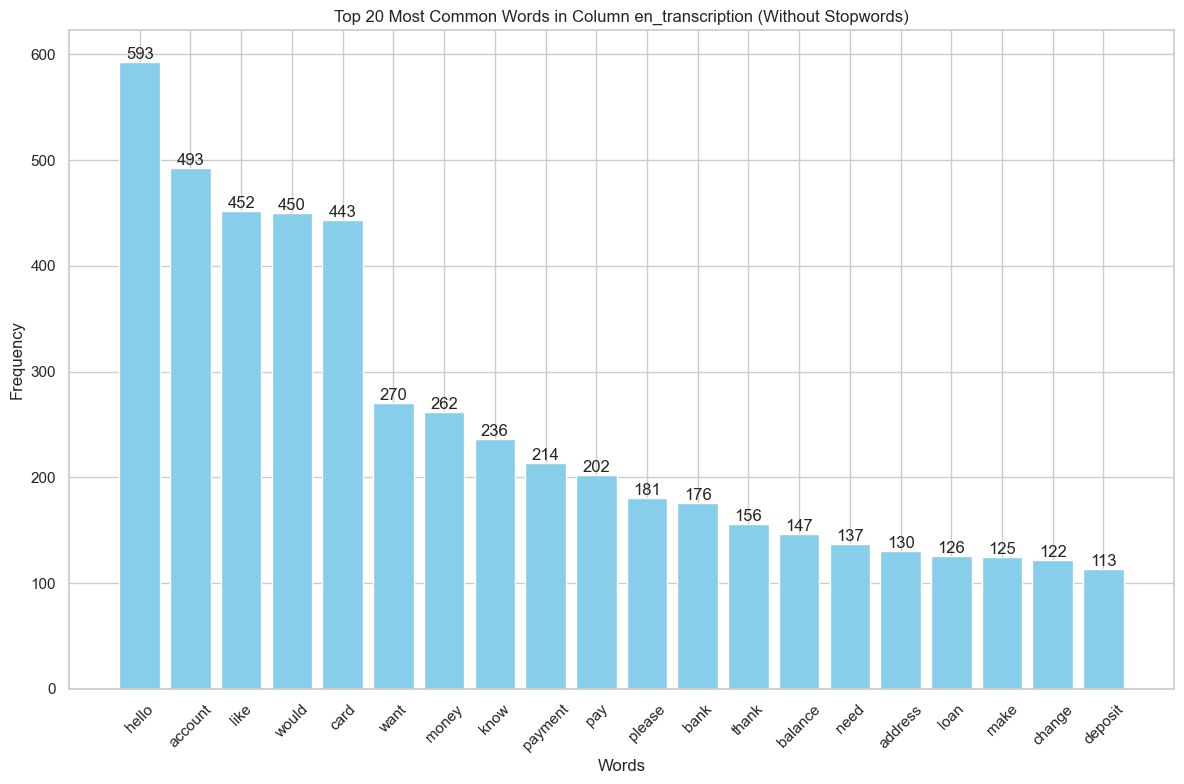

In [ ]:
# Top 20 Most Common Words in Column en_transcription (Without Stopwords)
# Load stopwords for English language
stop_words = set(stopwords.words('english'))

# Function to remove stopwords and non-alphabetic characters from text
def remove_stopwords_and_non_alpha(text):
    return [word.lower() for word in text if word.lower() not in stop_words and word.isalpha()]

# Combine all texts from 'en_transcription'
all_texts = ' '.join(train_df['en_transcription'].dropna())

# Tokenize and remove stopwords from all_texts
filtered_words = remove_stopwords_and_non_alpha(word_tokenize(all_texts))

# Count word frequencies
word_counts = Counter(filtered_words)

# Get top 20 most common words
top_20_words = word_counts.most_common(20)

# Visualize top 20 words using a bar chart
plt.figure(figsize=(12, 8))
words, counts = zip(*top_20_words)
bars = plt.bar(words, counts, color='skyblue')

# Add annotations to each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')

plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 Most Common Words in Column en_transcription (Without Stopwords)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Top 20 Most Common Bigrams in Column en_transcription (Without Stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andip\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\andip\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


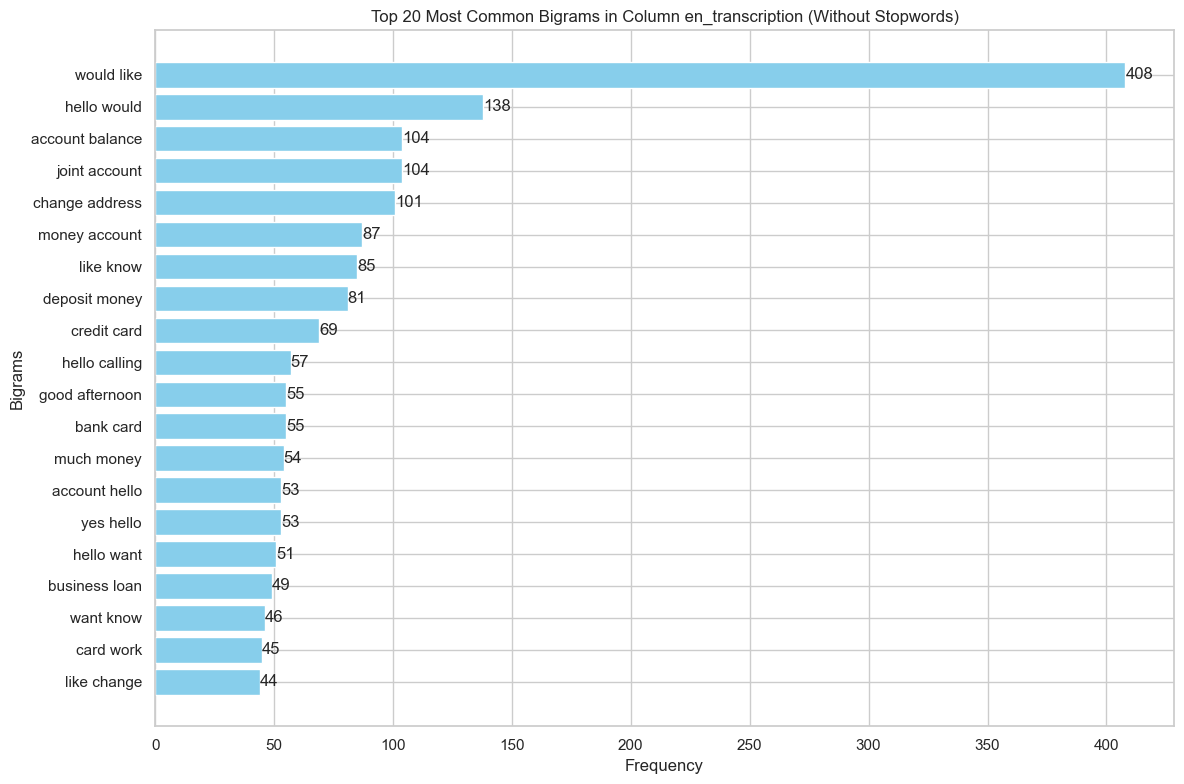

In [ ]:
# Function to remove stopwords and non-alphabetic characters from text
def remove_stopwords_and_non_alpha(text):
    return [word.lower() for word in text if word.lower() not in stop_words and word.isalpha()]

# Combine all texts from 'en_transcription'
all_texts = ' '.join(train_df['en_transcription'].dropna())

# Tokenize and remove stopwords from all_texts
filtered_words = remove_stopwords_and_non_alpha(word_tokenize(all_texts))

# Create bigrams from the filtered words
bigrams = ngrams(filtered_words, 2)

# Count bigram frequencies
bigram_counts = Counter(bigrams)

# Get top 20 most common bigrams
top_20_bigrams = bigram_counts.most_common(20)

# Format bigrams for plotting
bigram_labels = [' '.join(bigram) for bigram, count in top_20_bigrams]
bigram_counts = [count for bigram, count in top_20_bigrams]

# Reverse the order to have the highest frequency on top
bigram_labels.reverse()
bigram_counts.reverse()

# Visualize top 20 bigrams using a horizontal bar chart
plt.figure(figsize=(12, 8))
bars = plt.barh(bigram_labels, bigram_counts, color='skyblue')

# Add annotations to each bar
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, int(bar.get_width()), va='center', ha='left')

plt.xlabel('Frequency')
plt.ylabel('Bigrams')
plt.title('Top 20 Most Common Bigrams in Column en_transcription (Without Stopwords)')
plt.tight_layout()
plt.show()


## Top 20 Most Common Trigrams in Column en_transcription (Without Stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andip\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\andip\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


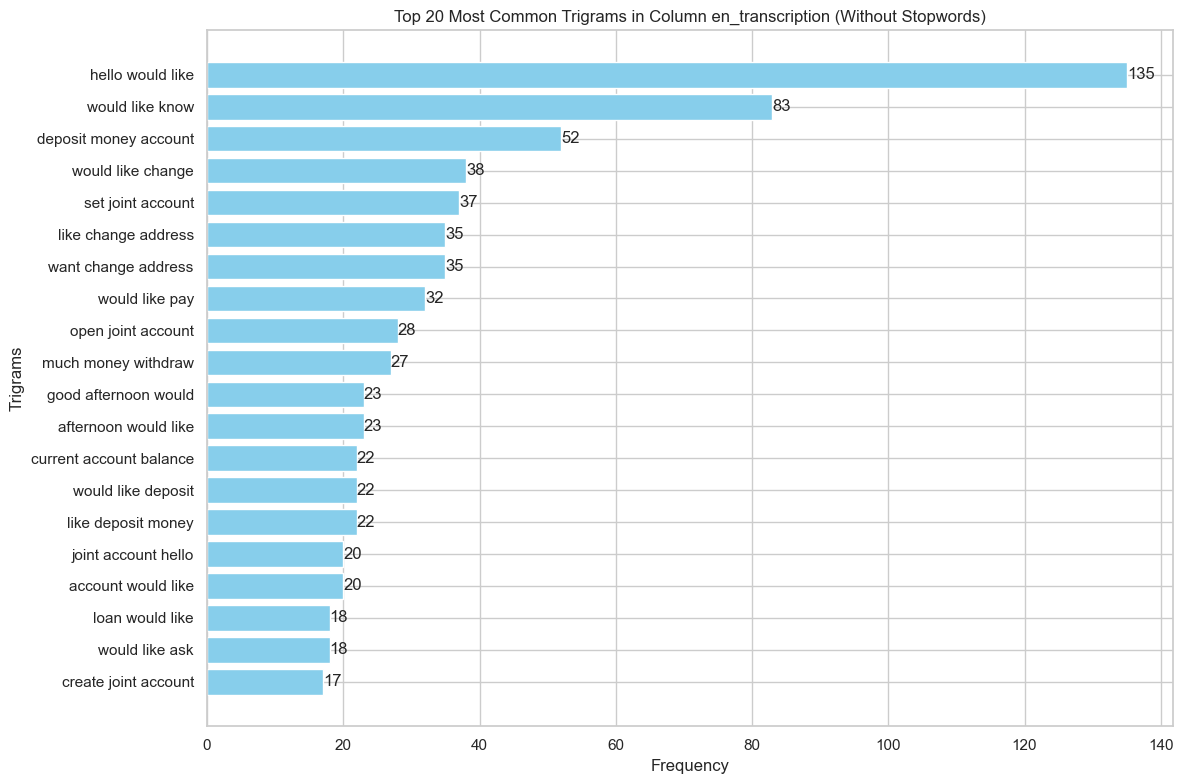

In [ ]:
# Function to remove stopwords and non-alphabetic characters from text
def remove_stopwords_and_non_alpha(text):
    return [word.lower() for word in text if word.lower() not in stop_words and word.isalpha()]

# Combine all texts from 'en_transcription'
all_texts = ' '.join(train_df['en_transcription'].dropna())

# Tokenize and remove stopwords from all_texts
filtered_words = remove_stopwords_and_non_alpha(word_tokenize(all_texts))

# Create trigrams from the filtered words
trigrams = ngrams(filtered_words, 3)

# Count trigram frequencies
trigram_counts = Counter(trigrams)

# Get top 20 most common trigrams
top_20_trigrams = trigram_counts.most_common(20)

# Format trigrams for plotting
trigram_labels = [' '.join(trigram) for trigram, count in top_20_trigrams]
trigram_counts = [count for trigram, count in top_20_trigrams]

# Reverse the order to have the highest frequency on top
trigram_labels.reverse()
trigram_counts.reverse()

# Visualize top 20 trigrams using a horizontal bar chart
plt.figure(figsize=(12, 8))
bars = plt.barh(trigram_labels, trigram_counts, color='skyblue')

# Add annotations to each bar
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, int(bar.get_width()), va='center', ha='left')

plt.xlabel('Frequency')
plt.ylabel('Trigrams')
plt.title('Top 20 Most Common Trigrams in Column en_transcription (Without Stopwords)')
plt.tight_layout()
plt.show()


## WordCloud from Column en_transcription (Without Stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andip\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\andip\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


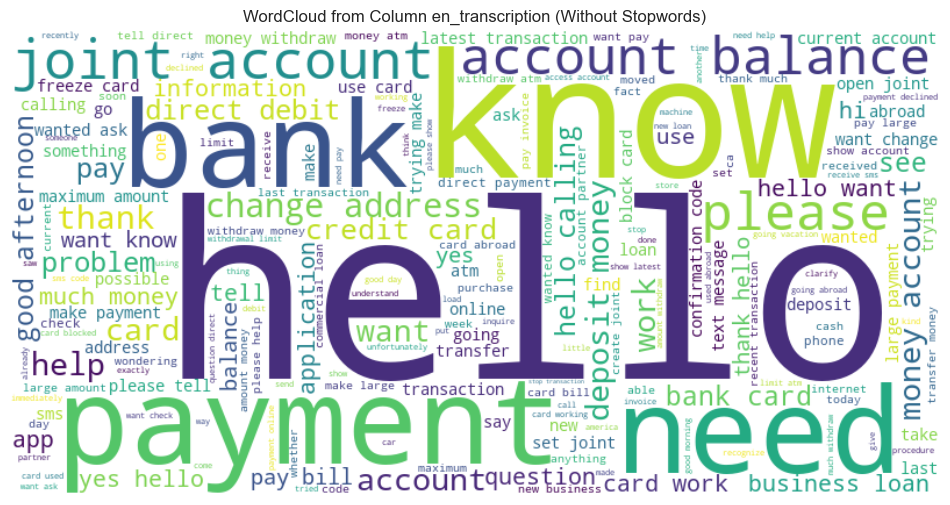

In [ ]:
# Function to remove stopwords and non-alphabetic characters from text
def remove_stopwords_and_non_alpha(text):
    return ' '.join([word.lower() for word in word_tokenize(text) if word.lower() not in stop_words and word.isalpha()])

# Combine all texts from 'en_transcription'
all_texts = ' '.join(train_df['en_transcription'].dropna())

# Apply function to remove stopwords and non-alphabetic characters
processed_text = remove_stopwords_and_non_alpha(all_texts)

# Generate WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(processed_text)

# Display WordCloud using matplotlib
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud from Column en_transcription (Without Stopwords)')
plt.show()
